In [1]:
# we defined a union mask created based on taking the max correlation from ses-01 and ses-02 reliability thresholds with ses-03, then taking the union between the two masks to apply to ses-03
# the goal was to hopefully capture most of the reliable voxels from ses-03 just based on ses-01 and ses-02
# here we would like to check how many of the reliable voxels calculated based on ses-03 are captured by the union mask

In [2]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib
import nilearn

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils
from utils import load_preprocess_betas, resample, applyxfm, apply_thresh, resample_betas

# imports utils from mindeye_preproc as "preproc"
import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 
    
seed = utils.get_slurm_seed()

importing modules
SLURM seed not found, using default: 0


In [3]:
if utils.is_interactive():
    sub = "sub-005"
    session = "ses-03"
    task = 'C'  # 'study' or 'A'; used to search for functional run in bids format
    func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
else:
    sub = os.environ["sub"]
    session = os.environ["session"]
    task = os.environ["task"]

if session == "all":
    ses_list = ["ses-01", "ses-02", "ses-03"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-02", "ses-03"]  # list of session IDs to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]
    
task_name = f"_task-{task}" if task != 'study' else ''
resample_voxel_size = False
resample_post_glmsingle = False  # do you want to do voxel resampling here? if resample_voxel_size = True and resample_post_glmsingle = False, assume the resampling has been done prior to GLMsingle, so just use resampled directory but otherwise proceed as normal
load_from_resampled_file = False  # do you want to load resampled data from file? if True, assume resampling was done in this notebook before, and that we're not using the GLMsingle resampled data
    
train_test_split = 'MST' # 'MST', 'orig', 'unique'
remove_close_to_MST = False
remove_random_n = False

if remove_close_to_MST or remove_random_n:
    assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

n_to_remove = 0
if remove_random_n:
    assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
    n_to_remove = 150
    
if resample_voxel_size:
    # voxel size was unchanged in glmsingle, want to perform resampling here
    resampled_vox_size = 2.5
    resample_method = "sinc"  # {trilinear,nearestneighbour,sinc,spline}, credit: https://johnmuschelli.com/fslr/reference/flirt.help.html
    
    # file name helper variables
    vox_dim_str = str(resampled_vox_size).replace('.', '_')  # in case the voxel size has a decimal, replace with an underscore
    resampled_suffix = f"resampled_{vox_dim_str}mm_{resample_method}"
    mask_resampled_suffix = resampled_suffix
    if resample_post_glmsingle:
        resampled_suffix += '_postglmsingle'
    else:
        resampled_suffix += '_preglmsingle'

In [4]:
session_label = preproc.get_session_label(ses_list)
print('session label:', session_label)
n_runs, _ = preproc.get_runs_per_session(sub, session, ses_list)

session label: ses-03


In [5]:
if utils.is_interactive():
    glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{task}"
else:
    glmsingle_path = os.environ["glmsingle_path"]
    
designdir = "/home/ri4541/real_time_mindEye2"
print(glmsingle_path)

if resample_voxel_size:
    # option 1: we are using original (non-resampled) GLMsingle outputs and doing the resampling here
    # option 2: doing resampling pre-GLMsingle and using those outputs; no resampling involved here
    if resample_post_glmsingle:
        # option 1
        orig_glmsingle_path = glmsingle_path
        glmsingle_path += f"_{resampled_suffix}"
        print("resampled glmsingle path:", glmsingle_path)
        if load_from_resampled_file:
            # resampling is already done; load from file
             assert os.path.exists(glmsingle_path)  # the new directory must have been created if we reached here
        else:
            # don't load from file; do resampling here
            os.makedirs(glmsingle_path,exist_ok=True)
    else:
        # option 2
        glmsingle_path += f"_{resampled_suffix}"
        print("glmsingle path:", glmsingle_path)

assert os.path.exists(glmsingle_path)
print("glmsingle path exists!")

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-03_task-C
glmsingle path exists!


loading brain mask
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 180585 voxels in the included brain mask



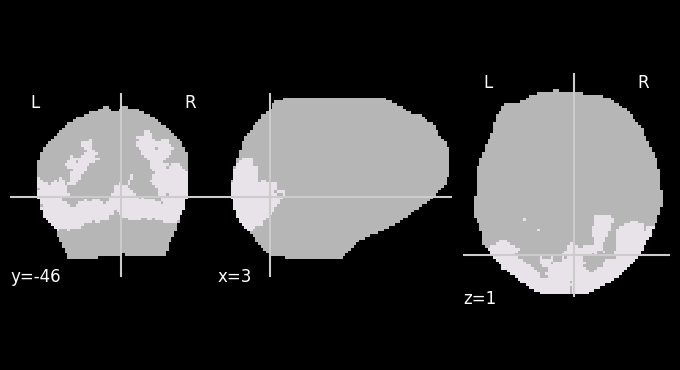

In [6]:
from nilearn.plotting import plot_roi
assert sub == 'sub-005' and session == "ses-03"
print('loading brain mask')
# func_masks, avg_mask, nsd_masks, roi = utils.get_mask(['ses-01', 'ses-02', 'ses-03'], sub, func_task_name)
final_brain = nib.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/sub-005_final_brain.nii.gz')
final_nsdgeneral = nib.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/sub-005_final_mask.nii.gz')

# mask info
dimsize=final_brain.header.get_zooms()
affine_mat = final_brain.affine
brain=final_brain.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

plot_roi(final_nsdgeneral, bg_img=final_brain)
plt.show()

In [7]:
union_mask = np.load('/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_task-C/union_mask_from_ses-01-02.npy')

In [8]:
# the union mask's shape is the same as the 1's in the final mask (which is the intersection of the nsdgeneral roi with all functional runs from ses-01, 02, 03
assert final_nsdgeneral.get_fdata().sum() == union_mask.shape[0]

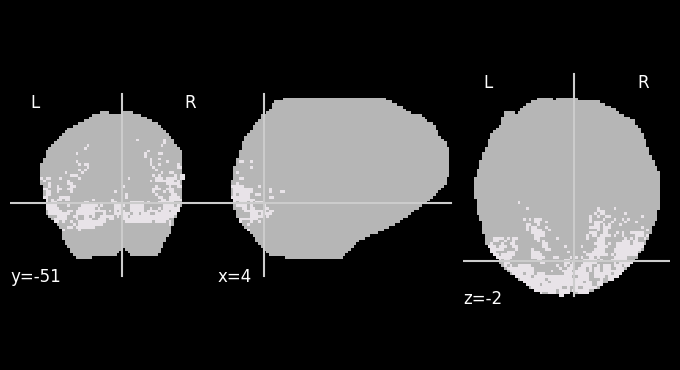

In [9]:
# since the union mask is a subset of the final mask, generate a nifti mask based on intersecting the union and final masks
u = nilearn.masking.unmask(union_mask, final_nsdgeneral)
plot_roi(u, bg_img=final_brain)
plt.show()

In [10]:
# generate ses-03 reliability mask

In [11]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = preproc.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [12]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = preproc.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
len_unique_images = len(unique_images)
print("n_runs",n_runs)

if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

if remove_random_n:
    # want to remove 150 imgs
    # 100 special515 imgs are repeated 3x (300 total)
    # all other train imgs are only shown once (558 total)
    # of the 150, want to sample proportionally since we're cutting all repeats for special515
    # so take out 51 (17 unique) from special515 and 99 from rest = removing 150 total
    np.random.seed(seed)
    options_to_remove = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' not in x and list(image_names).count(x)==1]  # all the imgs that only appear once (this is O(N^2) b/c of count() within list comprehension but image_names is a relatively small list)
    options_to_remove_special515 = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' in x and list(image_names).count(x)>1]  # all the special515 images that are repeated (count()>1 necessary because there are special515 that are not repeated)
    imgs_to_remove = np.random.choice(options_to_remove, size=99, replace=False)
    imgs_to_remove = np.append(imgs_to_remove, np.random.choice(options_to_remove_special515, size=17, replace=False))

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i+=1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i+=1
            continue
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):  # MST images are ones that matched these image titles
        import re
        if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):  
        # the regexp here looks for **_***.png, allows 1-2 chars before underscore and 1-3 chars after it
            # print(im)
            all_MST_images[i] = im
            i+=1            
    elif 'MST' in im:
        all_MST_images[i] = im
        i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)
if remove_close_to_MST:
    close_to_MST_idx = np.array([], dtype=int)
if remove_random_n:
    random_n_idx = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            i+=1
            continue
    if remove_random_n:
        if im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            i+=1
            j+=1
            continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100

Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532
n_runs 11
['all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png'
 'all_stimuli/special515/special_67295.jpg'
 'all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png'
 'all_stimuli/special515/special_70232.jpg']
[174.7109683 178.7049172 182.7072832 186.7297016]
[0. 0. 0. 0.]
(693,)


In [13]:
vox = None
needs_postprocessing = False
params = (session, ses_list, remove_close_to_MST, image_names, remove_random_n, vox_idx)

if resample_post_glmsingle == True:
    glm_save_path_resampled = f"{glmsingle_path}/vox_resampled.nii.gz"
    if load_from_resampled_file == True:
        # resampling was done in this notebook so we can load from file
        vox = nib.load(glm_save_path_resampled)
    else:
        # do resampling here
        assert os.path.exists(ref_name) and os.path.exists(omat_name), "need to generate the boldref and omat separately since we don't have access to the functional data here; either do so using flirt on the command line or copy over the glmsingle resampled outputs"
        vox = load_preprocess_betas(orig_glmsingle_path, *params)
        vox = resample_betas(orig_glmsingle_path, sub, session, task_name, vox, glmsingle_path, glm_save_path_resampled, ref_name, omat_name)
    needs_postprocessing = True

if vox is None:
    # either resampling was done in glmsingle or we aren't resampling 
    vox = load_preprocess_betas(glmsingle_path, *params)

if needs_postprocessing == True:
    vox = apply_mask(vox, final_brain)
    vox = vox.reshape(-1, vox.shape[-1])  # flatten the 3D image into np array with shape (voxels, images)
    print(vox.shape)

assert len(vox) == len(image_idx)

vox (693, 1, 1, 183408)
vox (693, 183408)


In [14]:
a = final_brain.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(a.sum())}")
roi = final_nsdgeneral
roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[a.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"final_mask voxels = {roi.sum()}")

total voxels (whole brain) = 180585
final_mask voxels = 19174


In [15]:
ses_mask = nib.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_{session_label}_task-C/sub-005_{session_label}_task-C_brain.nii.gz')
assert np.all(ses_mask.affine == final_brain.affine)
assert np.all(ses_mask.shape == final_brain.shape)

In [16]:
v = nilearn.masking.unmask(vox, ses_mask)  # move back to 3D based on own session mask
vox = nilearn.masking.apply_mask(v, final_brain)  # re-flatten based on final mask so everything is in the same shape now
print(vox.shape)
vox = vox[:, roi]
print("applied final nsdgeneral roi mask")
print(vox.shape)

(693, 180585)
applied final nsdgeneral roi mask
(693, 19174)


In [17]:
image_idx = np.array([])  # contains the unique index of each presented image
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i+=1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i+=1
            continue
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
image_idx = torch.Tensor(image_idx).long()

In [18]:
pairs = utils.find_paired_indices(image_idx)
pairs = sorted(pairs, key=lambda x: x[0])

In [19]:
pairs_homog = np.array([[p[0], p[1]] for p in pairs])

In [20]:
vox_pairs = utils.zscore(vox[pairs_homog])
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape)
assert np.sum(np.all(np.isnan(rels))) == 0

100%|██████████| 19174/19174 [00:01<00:00, 17557.86it/s]

rels (19174,)


In [21]:
# creating img x vox x repetitions matrix | shape=(150, 18419, 2)
vox0 = np.zeros((len(pairs_homog), vox.shape[-1], 2))
print(vox0.shape)
for ipair, pair in enumerate(tqdm(pairs_homog)):
    pair = pair[:2] # to keep things consistent, just using the first two repeats
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T
vox_avg = vox0.mean(-1) # average across the repetitions

(112, 19174, 2)


100%|██████████| 112/112 [00:00<00:00, 3502.37it/s]


In [22]:
# Masking RDM for each reliability threshold
r_thresholds = np.array([.2])
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            rdm[ir_thresh,i,j] = np.corrcoef(vox_avg[i,rels>r_thresh], 
                                             vox_avg[j,rels>r_thresh])[0,1]
# rdm is shape (4, 150, 150)

reliability threshold = 0.2


100%|██████████| 112/112 [00:02<00:00, 48.02it/s]


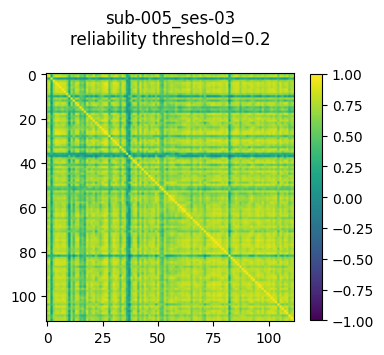

In [23]:
thresh = .2
plt.figure(figsize=(4,4))
plt.imshow(rdm[np.where(r_thresholds==thresh)[0].item()], clim=(-1,1))
plt.colorbar(shrink=0.8)
plt.title(f"{sub}_{session}\nreliability threshold={thresh}\n")
plt.show()

In [24]:
for thresh in range(rdm.shape[0]):
    for img in range(rdm.shape[1]):
        assert np.isclose(rdm[thresh, img, img], 1)

In [25]:
# # Reliability thresholding?
# print(f"\nvox before reliability thresholding: {vox.shape}")
# vox = vox[:,rels>.2]
# print(f"\nvox after reliability thresholding: {vox.shape}")

In [26]:
# now rel_mask is a reliability mask with the same shape as final_nsdgeneral
# union mask also has the same shape so they can be compared directly
rel_mask = rels>.2
assert rel_mask.shape == union_mask.shape
print(rel_mask.shape)

(19174,)


In [27]:
# what's the overlap between the two masks and the final_nsdgeneral roi?
print(f"ses-03 reliability mask (threshold > 0.2): {(rel_mask.sum() / rel_mask.shape[0]):.2%} of nsdgeneral roi ({rel_mask.sum()}/{rel_mask.shape[0]} voxels)")
print(f"ses-01 and 02 derived union mask: {(union_mask.sum() / rel_mask.shape[0]):.2%} of nsdgeneral roi ({union_mask.sum()}/{rel_mask.shape[0]} voxels)")

ses-03 reliability mask (threshold > 0.2): 10.99% of nsdgeneral roi (2107/19174 voxels)
ses-01 and 02 derived union mask: 44.99% of nsdgeneral roi (8627/19174 voxels)


In [28]:
# what's the overlap between the two masks as a percent?
overlap = np.sum(union_mask & rel_mask)
overlap_pct = overlap / rel_mask.sum()
print(f"{overlap_pct:.2%} overlap between reliability and union mask ({overlap}/{rel_mask.sum()} voxels)")

81.30% overlap between reliability and union mask (1713/2107 voxels)


In [29]:
# how many of the union mask voxels are not in the reliability mask? 

print(f"{((union_mask.sum() - overlap) / union_mask.sum()):.2%} ({union_mask.sum() - overlap}/{union_mask.sum()}) voxels in the union mask have reliability < 0.2 in ses-03 (are not present in the reliability mask)")

80.14% (6914/8627) voxels in the union mask have reliability < 0.2 in ses-03 (are not present in the reliability mask)
